# Imports

In [1]:
# Global imports
import os
import numpy as np
import pickle
import pandas as pd
import imageio.v2 as imageio
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import glob
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
import torchaudio

d:\Users\herna\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\Users\herna\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading the data

## Global data

We first load the CSV file with the data of all participants, then we will use it to make a wider dataset with all the recordings

In [8]:
base_path = 'D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ\data'
df_train = pd.read_csv('D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/DAIC-WOZ/train_split_Depression_AVEC2017.csv')
df_test = pd.read_csv('D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/DAIC-WOZ/test_split_Depression_AVEC2017.csv')
df_test_full = pd.read_csv('D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/DAIC-WOZ/full_test_split.csv')
df_dev = pd.read_csv('D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/DAIC-WOZ/dev_split_Depression_AVEC2017.csv')

#### Standarizing data


In [9]:
df_test_full['PHQ8_Binary'] = df_test_full['PHQ_Binary']
df_test_full.drop('PHQ_Binary', axis=1, inplace=True)
df_complete = pd.concat([df_test_full, df_dev, df_train], axis=0)
print(f'df_train: {df_train.shape[0]} rows\n'
      f'df_test_full: {df_test_full.shape[0]} rows\n'
      f'df_dev: {df_dev.shape[0]} rows\n'
      f'Total: {df_train.shape[0] + df_test_full.shape[0] + df_dev.shape[0]} rows \n\n'
      
      f'df_complete: {df_complete.shape[0]} rows\n'
      f'df_test: {df_test.shape[0] + df_test.shape[0] + df_test.shape[0]} rows (DISCARD)\n')
      


df_train: 107 rows
df_test_full: 47 rows
df_dev: 35 rows
Total: 189 rows 

df_complete: 189 rows
df_test: 141 rows (DISCARD)



In [10]:
df_complete

,Participant_ID,PHQ_Score,Gender,PHQ8_Binary,PHQ8_Score,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,300,2.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,301,3.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,306,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,308,22.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,309,15.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,485,NaN,1,0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
103,486,NaN,0,0,4.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
104,487,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,488,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Checking types

In [11]:
df_complete.dtypes

Participant_ID          int64
PHQ_Score             float64
Gender                  int64
PHQ8_Binary             int64
PHQ8_Score            float64
PHQ8_NoInterest       float64
PHQ8_Depressed        float64
PHQ8_Sleep            float64
PHQ8_Tired            float64
PHQ8_Appetite         float64
PHQ8_Failure          float64
PHQ8_Concentrating    float64
PHQ8_Moving           float64
dtype: object

### Treat data frame as dict

In [12]:
df_dict = df_complete.set_index('Participant_ID').to_dict('index')
df_dict

{300: {'PHQ_Score': 2.0,
  'Gender': 1,
  'PHQ8_Binary': 0,
  'PHQ8_Score': nan,
  'PHQ8_NoInterest': nan,
  'PHQ8_Depressed': nan,
  'PHQ8_Sleep': nan,
  'PHQ8_Tired': nan,
  'PHQ8_Appetite': nan,
  'PHQ8_Failure': nan,
  'PHQ8_Concentrating': nan,
  'PHQ8_Moving': nan},
 301: {'PHQ_Score': 3.0,
  'Gender': 1,
  'PHQ8_Binary': 0,
  'PHQ8_Score': nan,
  'PHQ8_NoInterest': nan,
  'PHQ8_Depressed': nan,
  'PHQ8_Sleep': nan,
  'PHQ8_Tired': nan,
  'PHQ8_Appetite': nan,
  'PHQ8_Failure': nan,
  'PHQ8_Concentrating': nan,
  'PHQ8_Moving': nan},
 306: {'PHQ_Score': 0.0,
  'Gender': 0,
  'PHQ8_Binary': 0,
  'PHQ8_Score': nan,
  'PHQ8_NoInterest': nan,
  'PHQ8_Depressed': nan,
  'PHQ8_Sleep': nan,
  'PHQ8_Tired': nan,
  'PHQ8_Appetite': nan,
  'PHQ8_Failure': nan,
  'PHQ8_Concentrating': nan,
  'PHQ8_Moving': nan},
 308: {'PHQ_Score': 22.0,
  'Gender': 0,
  'PHQ8_Binary': 1,
  'PHQ8_Score': nan,
  'PHQ8_NoInterest': nan,
  'PHQ8_Depressed': nan,
  'PHQ8_Sleep': nan,
  'PHQ8_Tired': nan,
  'PHQ

### Helper function definition

#### Spectrogram generator

In [33]:
import os
import re
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def extract_participant_id(directory_name):
    match = re.match(r"(\d+)_P", directory_name)
    if match:
        return int(match.group(1))
    return None

def load_audios_for_participants(base_path):
    """
    Load audios for each participant from their respective directories,
    and generate both standard and Mel spectrograms.
    
    Args:
    - base_path (str): Base path where participant directories are located.
    
    Returns:
    - data_dict (dict): Dictionary with the loaded audios and their spectrograms.
    """
    data_dict = {}
    participant_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    print(f"Found {len(participant_dirs)} participant directories.")

    for directory in participant_dirs:
        print(f"Processing directory: {directory}")
        participant_id = extract_participant_id(directory)
        if participant_id is not None:
            print(f"Participant ID: {participant_id}")
            audio_file_name = f"cleaned_preprocessed_{participant_id}_AUDIO.wav"
            audio_path = os.path.join(base_path, directory, audio_file_name)
            print(f"Looking for audio file: {audio_path}")

            if os.path.exists(audio_path):
                print("Audio file found. Loading...")
                audio_time_series, sample_rate = librosa.load(audio_path)
                print("Audio loaded. Generating spectrograms...")

                # Generate the STFT spectrogram
                stft_spectrogram = librosa.stft(audio_time_series)
                spectrogram_db = librosa.amplitude_to_db(np.abs(stft_spectrogram), ref=np.max)
                
                # Generate the Mel spectrogram
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_time_series, sr=sample_rate)
                mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
                
                print("Spectrograms generated.")

                # Update data_dict with audio and spectrogram info
                                # Correctly update data_dict with audio and spectrogram info
                if participant_id not in data_dict:
                    data_dict[participant_id] = {'audios': {'sm': {}}}
                
                data_dict[participant_id]['audios']["sm"][1] = {
                    'file_path': audio_path,
                    'waveform': audio_time_series,
                    'sample_rate': sample_rate,
                    'spectrogram': spectrogram_db,
                    'mel_spectrogram': mel_spectrogram_db
                }
                print(f"Data for participant {participant_id} added to dictionary.")
                print(f"Data for participant {participant_id} added to dictionary.")
            else:
                print("Audio file not found.")
        else:
            print("Participant ID not found in directory name.")
                
    print("All directories processed.")
    return data_dict


In [34]:
# Example usage
base_path = "D:\\Github\\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\\DAIC-WOZ\\data"
data_dict = load_audios_for_participants(base_path)


# Verify the content of the updated dictionary
data_dict

Found 189 participant directories.
Processing directory: 300_P
Participant ID: 300
Looking for audio file: D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ\data\300_P\cleaned_preprocessed_300_AUDIO.wav
Audio file found. Loading...
Audio loaded. Generating spectrograms...
Spectrograms generated.
Data for participant 300 added to dictionary.
Data for participant 300 added to dictionary.
Processing directory: 301_P
Participant ID: 301
Looking for audio file: D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ\data\301_P\cleaned_preprocessed_301_AUDIO.wav
Audio file found. Loading...
Audio loaded. Generating spectrograms...
Spectrograms generated.
Data for participant 301 added to dictionary.
Data for participant 301 added to dictionary.
Processing directory: 302_P
Participant ID: 302
Looking for audio file: D:\Github\Improving-deep-neural-networks-to-identify-mental-d

{300: {'audios': {'sm': {1: {'file_path': 'D:\\Github\\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\\DAIC-WOZ\\data\\300_P\\cleaned_preprocessed_300_AUDIO.wav',
     'waveform': array([-4.1351461e-07, -1.8941876e-06,  5.0373619e-06, ...,
             0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
     'sample_rate': 22050,
     'spectrogram': array([[-64.39727 , -51.001404, -44.458214, ..., -80.      , -80.      ,
             -80.      ],
            [-67.87445 , -54.23931 , -47.566956, ..., -80.      , -80.      ,
             -80.      ],
            [-80.      , -59.209534, -55.96752 , ..., -80.      , -80.      ,
             -80.      ],
            ...,
            [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
             -80.      ],
            [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
             -80.      ],
            [-80.      , -80.      , -80.      , ..., -80.

#### Export to pickle to save and load the data

In [42]:
def save_data_dict_to_file(filename, data_dict):
    """
    Save the data_dict dictionary to a file using pickle.

    Parameters:
    - filename (str): The name of the file to save the data_dict to.
    - data_dict (dict): The dictionary containing the data to be saved.

    Returns:
    None
    """
    # Open a file in write-binary (wb) mode
    with open(filename, 'wb') as file:
        # Use pickle.dump() to write the data_dict dictionary to the file
        pickle.dump(data_dict, file)

    print(f'data_dict has been saved to {filename}')

# Specify the filename for saving
filename = 'DAIC-WOZ.pkl'

# Call the save_data_dict_to_file function to save the data_dict_updated dictionary
save_data_dict_to_file(filename, data_dict)


data_dict has been saved to DAIC-WOZ.pkl


In [43]:
def load_data(filename):
    """
    Load data from a pickle file.

    Args:
        filename (str): The path to the pickle file.

    Returns:
        dict: The loaded data dictionary.
    """
    with open(filename, 'rb') as file:
        data_dict_loaded = pickle.load(file)
    return data_dict_loaded

data_dict_loaded = load_data(filename)
data_dict_loaded

{300: {'audios': {'sm': {1: {'file_path': 'D:\\Github\\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\\DAIC-WOZ\\data\\300_P\\cleaned_preprocessed_300_AUDIO.wav',
     'waveform': array([-4.1351461e-07, -1.8941876e-06,  5.0373619e-06, ...,
             0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
     'sample_rate': 22050,
     'spectrogram': array([[-64.39727 , -51.001404, -44.458214, ..., -80.      , -80.      ,
             -80.      ],
            [-67.87445 , -54.23931 , -47.566956, ..., -80.      , -80.      ,
             -80.      ],
            [-80.      , -59.209534, -55.96752 , ..., -80.      , -80.      ,
             -80.      ],
            ...,
            [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
             -80.      ],
            [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
             -80.      ],
            [-80.      , -80.      , -80.      , ..., -80.

#### Testing the spectrograms

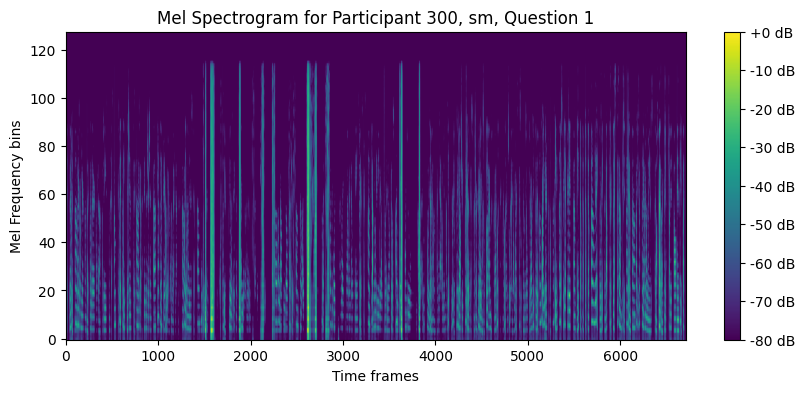

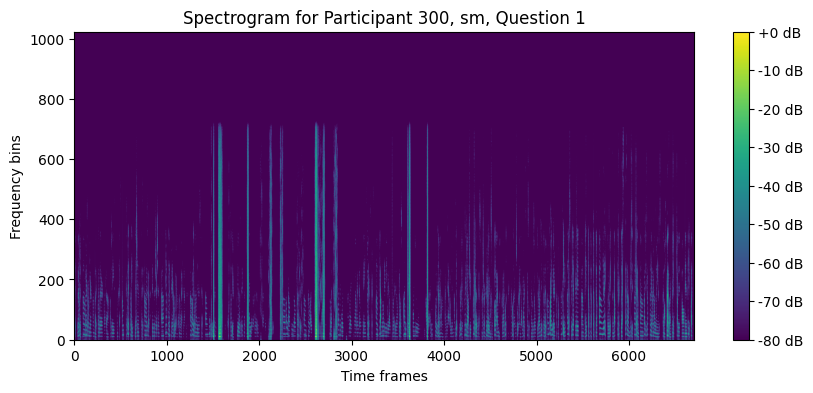

In [44]:
import matplotlib.pyplot as plt
import numpy as np

participant_id = 300  # Replace with the actual participant ID
audio_type = 'sm'  # Replace with 'sm' or 'mobile'
question_number = 1  # Replace with the actual question number

# Retrieve both spectrograms
mel_spectrogram_data = data_dict[participant_id]['audios']['sm'][1]['mel_spectrogram']
spectrogram_data = data_dict[participant_id]['audios']['sm'][1]['spectrogram']

# Convert the Mel spectrogram to a numpy array if it's a tensor
if not isinstance(mel_spectrogram_data, np.ndarray):
    mel_spectrogram_data = mel_spectrogram_data.numpy()

# Convert the standard spectrogram to a numpy array if it's a tensor
if not isinstance(spectrogram_data, np.ndarray):
    spectrogram_data = spectrogram_data.numpy()

# Squeeze both spectrograms
mel_spectrogram_data = np.squeeze(mel_spectrogram_data)
spectrogram_data = np.squeeze(spectrogram_data)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram_data, aspect='auto', origin='lower')
plt.title(f'Mel Spectrogram for Participant {participant_id}, {audio_type}, Question {question_number}')
plt.ylabel('Mel Frequency bins')
plt.xlabel('Time frames')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Plot the standard spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram_data, aspect='auto', origin='lower')
plt.title(f'Spectrogram for Participant {participant_id}, {audio_type}, Question {question_number}')
plt.ylabel('Frequency bins')
plt.xlabel('Time frames')
plt.colorbar(format='%+2.0f dB')
plt.show()

## SM-27

In [37]:
df_test[152]['audios']["mobile"][1].keys()

dict_keys(['sm', 'mobile'])

In [ ]:
df_sm =""

## iPhone SE 2020

In [ ]:
df_iphone=  ""

# Data processing

## Spectrograms